In [1]:
import matplotlib.pyplot as plt
import torch

from utils import *
from core import *

device = torch.device('cuda')


In [2]:
# add code of core file (if running online)

# hot reload if running locally
%load_ext autoreload
%autoreload 2

In [3]:
gc.collect()
torch.cuda.empty_cache()

In [4]:
n = 100

cim = CreateInterceptMatrix(
    detector_plate_length=n,
    source_to_detector=200,
    source_to_object=160,
    pixel_size=48/n,
    projections=n,
    dtype=torch.float32
)

## Generate Rays

In [5]:
n = 200
ps = 48/n
dtype = torch.float32
x = torch.arange(-n + 1, n, 2, device=device, dtype=dtype) / 2 * ps
x

tensor([-23.8800, -23.6400, -23.4000, -23.1600, -22.9200, -22.6800, -22.4400,
        -22.2000, -21.9600, -21.7200, -21.4800, -21.2400, -21.0000, -20.7600,
        -20.5200, -20.2800, -20.0400, -19.8000, -19.5600, -19.3200, -19.0800,
        -18.8400, -18.6000, -18.3600, -18.1200, -17.8800, -17.6400, -17.4000,
        -17.1600, -16.9200, -16.6800, -16.4400, -16.2000, -15.9600, -15.7200,
        -15.4800, -15.2400, -15.0000, -14.7600, -14.5200, -14.2800, -14.0400,
        -13.8000, -13.5600, -13.3200, -13.0800, -12.8400, -12.6000, -12.3600,
        -12.1200, -11.8800, -11.6400, -11.4000, -11.1600, -10.9200, -10.6800,
        -10.4400, -10.2000,  -9.9600,  -9.7200,  -9.4800,  -9.2400,  -9.0000,
         -8.7600,  -8.5200,  -8.2800,  -8.0400,  -7.8000,  -7.5600,  -7.3200,
         -7.0800,  -6.8400,  -6.6000,  -6.3600,  -6.1200,  -5.8800,  -5.6400,
         -5.4000,  -5.1600,  -4.9200,  -4.6800,  -4.4400,  -4.2000,  -3.9600,
         -3.7200,  -3.4800,  -3.2400,  -3.0000,  -2.7600,  -2.52

(torch.Size([2, 200, 200]), torch.Size([200, 200]), torch.Size([200, 200]))

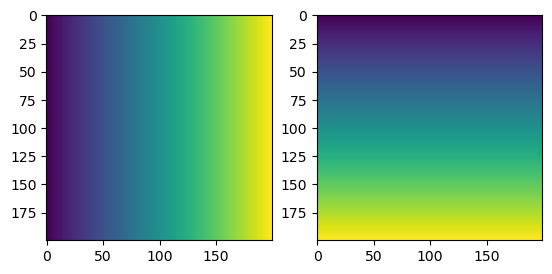

In [6]:
detector_coords = torch.stack(torch.meshgrid(x, x, indexing='xy'), 0)
a = detector_coords[0]
b = detector_coords[1]

plt.subplot(1, 2, 1)
plt.imshow(a.cpu())
plt.subplot(1, 2, 2)
plt.imshow(b.cpu())
detector_coords.shape, a.shape, b.shape

In [7]:
phis = torch.linspace(0, torch.pi/2, 10, device=device, dtype=dtype).reshape(-1, 1, 1)
phis.shape

torch.Size([10, 1, 1])

In [8]:
mu = 40
lambd = 160
c = torch.cos(phis)
s = torch.sin(phis)
c.shape

torch.Size([10, 1, 1])

In [9]:
alphas = (a * lambd + lambd * mu * s) / (a * s + mu + lambd * c ** 2)
betas = b / (1 - (mu + alphas * s) / (alphas * s - lambd))

alphas.shape, betas.shape, phis.shape

(torch.Size([10, 200, 200]),
 torch.Size([10, 200, 200]),
 torch.Size([10, 1, 1]))

In [22]:
a = ((alphas < 0.000001).to_sparse_coo())
a

tensor(indices=tensor([[  0,   0,   0,  ...,   3,   3,   3],
                       [  0,   0,   0,  ..., 199, 199, 199],
                       [  0,   1,   2,  ...,  14,  15,  16]]),
       values=tensor([True, True, True,  ..., True, True, True]),
       device='cuda:0', size=(10, 200, 200), nnz=46200, layout=torch.sparse_coo)

In [31]:
len(a.values())

46200

In [77]:
w = torch.broadcast_to(phis, [10, 200, 200])
e = phis + torch.zeros_like(alphas)
torch.allclose(w, e)

True

## Complete code